In [3]:
import pandas as pd
import numpy as np
import re
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore') #headache management
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score




#basic count rows

df = pd.read_csv("Shark%2C_Skate_or_Ray_Species_Distribution.csv")
spec_dist_clean = df.replace(r'^\s*$', np. nan, regex=True).dropna(how='all')

ray_columns = ['cntBlondeRay', 'cntCuckooRay', 'cntElectricRay', 'cntHomelynRay',
               'cntPaintedRay', 'cntSandyRay', 'cntStingray', 'cntThornbackRay', 'cntUndulateRay']
shark_columns = ['cntAngelshark', 'cntBlackmouthedDogfish', 'cntBlueShark', 'cntBullHuss',
                 'cntLesserSpottedDogfish', 'cntMakoShark', 'cntPorbeagleShark',
                 'cntSixGilledShark', 'cntSmoothHound', 'cntSpurdog', 'cntThresherShark', 'cntTope']

spec_dist_clean['Total_Rays'] = df[ray_columns].sum(axis=1)
spec_dist_clean['Total_Sharks'] = df[shark_columns].sum(axis=1)
spec_dist_clean = spec_dist_clean.rename(columns={'cntCommonSkateSpeciesComplex': 'Total_Skates'})



In [4]:
#ICES code conversion to latitude/longitude centroids

LAT0, LON0 = 36.0, -44.0
COL_LETTERS = [chr(x) for x in range(ord('A'), ord('M')+1) if chr(x) != 'I']

def ices_centroid_from_code(code):
    if not isinstance(code, str) or len(code) < 4:
        return (None, None)
    code = code.strip(). upper()
    m = re.match(r'^(\d{2})([A-Z])(\d)$', code[:4])
    if not m:
        return (None, None)
    row, col_letter, col_digit = int(m.group(1)), m.group(2), int(m.group(3))
    if col_letter not in COL_LETTERS:
        return (None, None)
    lat_cent = LAT0 + (row - 1) * 0.5 + 0.25
    lon_cent = LON0 + (COL_LETTERS.index(col_letter) * 10 + col_digit) + 0.5
    return (round(lat_cent, 6), round(lon_cent, 6))

def add_ices_centroids_df(df, ices_col='ICESNAME', sub_col='sub_code'):
    df = df.copy()
    def pick_code(row):
        s = row. get(sub_col, '')
        if isinstance(s, str) and s. strip():
            return s.strip()
        return row. get(ices_col, '').strip() if row.get(ices_col) is not None else ''
    codes = df. apply(pick_code, axis=1)
    coords = codes.map(lambda c: ices_centroid_from_code(c) if c else (None, None))
    df['centroid_lat'] = coords. map(lambda x: x[0])
    df['centroid_lon'] = coords.map(lambda x: x[1])
    return df

def get_ices_sea_area(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return (None, None)
    if 53.5 <= lat <= 66 and 9 <= lon <= 30:
        return ('IIIa', 'Skagerrak and Kattegat') if lat >= 57.5 and lon <= 12 else ('IIId', 'Baltic Sea')
    if lat >= 62 and -4 <= lon <= 20:
        return ('IIa', 'Norwegian Sea')
    if 51 <= lat <= 62 and -4 <= lon <= 9:
        if lat >= 57.5:
            return ('IVa', 'Northern North Sea')
        elif lat >= 53.5:
            return ('IVb', 'Central North Sea')
        return ('IVc', 'Southern North Sea')
    if 48 <= lat <= 56 and -18 <= lon <= 0:
        return ('VII', 'Celtic Seas')
    return ('Unknown', 'Unknown Area')

spec_dist_with_centroids = add_ices_centroids_df(spec_dist_clean)
spec_dist_with_centroids['division_code'], spec_dist_with_centroids['sea_area'] = zip(
    *spec_dist_with_centroids. apply(lambda row: get_ices_sea_area(row['centroid_lat'], row['centroid_lon']), axis=1))

spec_dist_final = spec_dist_with_centroids.drop(columns=['ICESNAME', 'sub_code', 'Shape__Area', 'Shape__Length', 'division_code'])

print(f"Preprocessed {len(spec_dist_final)} records")
print(spec_dist_final[['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays']].head())

Preprocessed 503 records
             sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays
0         Celtic Seas         51.75          -4.5             7           1
1         Celtic Seas         51.75          -4.5           103          36
2         Celtic Seas         51.75          -4.5             0           8
3  Southern North Sea         51.25          -3.5            16          11
4  Southern North Sea         52.25          -3.5            11           3


In [5]:
#Data Extraction from .nc files
#This data was gotten from data.marine.copernicus.eu
#In each of these files i have selected the range -8 - 8 lon, and 39 - 56 lat

print("Extracting environmental data...")

df = spec_dist_final.copy()

#.nc file manipulation

def extract_environmental_data(df, nc_file, var_name, output_col):
    if not os.path. exists(nc_file):
        print(f"File not found: {nc_file}")
        df[output_col] = None
        return df

    try:
        ds = xr.open_dataset(nc_file)

        if isinstance(var_name, str):
            var_name = [var_name]

        found_var = next((v for v in var_name if v in ds.data_vars), None)
        if not found_var:
            df[output_col] = None
            ds.close()
            return df

        lat_coord = next((c for c in ['lat', 'latitude', 'y'] if c in ds.coords), None)
        lon_coord = next((c for c in ['lon', 'longitude', 'x'] if c in ds.coords), None)
        time_coord = next((c for c in ['time', 't'] if c in ds.coords), None)
        depth_coord = next((c for c in ['depth', 'lev', 'z'] if c in ds.coords), None)

        if not lat_coord or not lon_coord:
            df[output_col] = None
            ds.close()
            return df

        values = []
        valid_count = 0

        for idx, row in df.iterrows():
            lat = row['centroid_lat']
            lon = row['centroid_lon']

            if pd.notna(lat) and pd.notna(lon):
                try:
                    point = ds[found_var].sel({lat_coord: lat, lon_coord: lon}, method='nearest')

                    if time_coord and time_coord in point.dims:
                        point = point.mean(dim=time_coord)

                    if depth_coord and depth_coord in point.dims:
                        point = point.isel({depth_coord: -1})

                    val = float(point. values)

                    if not (np.isnan(val) or np.isinf(val) or val < -9999):
                        values.append(val)
                        valid_count += 1
                    else:
                        values.append(None)

                except:
                    values.append(None)
            else:
                values.append(None)

        df[output_col] = values
        ds.close()

        print(f"{output_col}: {valid_count}/{len(df)} valid values ({valid_count/len(df)*100:.1f}%)")

        return df

    except Exception as e:
        print(f"Error processing {nc_file}: {e}")
        df[output_col] = None
        return df

#Was orignially going to use copernicus' toolbox api to do this, but after 2 hours of fuckery i decided to just do it manually. saves on
#time as well

Extracting environmental data...


In [6]:
#Adding to the csv

df = extract_environmental_data(df, 'TEMP.nc', ['bottomT', 'thetao', 'temperature', 'temp'], 'bottom_temp_C')
df = extract_environmental_data(df, 'SALINE.nc', ['so', 'salinity', 'sal'], 'salinity_psu')
df = extract_environmental_data(df, 'DEPTH.nc', ['mlotst', 'mld', 'mixed_layer_depth', 'depth'], 'mixed_layer_depth_m')

output_file = 'species_distribution_complete.csv'
df.to_csv(output_file, index=False)

print(f"\nSaved to: {output_file}")

display_cols = ['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays', 'bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']
display_cols = [c for c in display_cols if c in df.columns]
print(f"\nSample data:")
print(df[display_cols].head(10). to_string(index=False))

bottom_temp_C: 209/503 valid values (41.6%)
salinity_psu: 210/503 valid values (41.7%)
mixed_layer_depth_m: 209/503 valid values (41.6%)

Saved to: species_distribution_complete.csv

Sample data:
          sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays  bottom_temp_C  salinity_psu  mixed_layer_depth_m
       Celtic Seas         51.75          -4.5             7           1      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5           103          36      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5             0           8      12.129351           NaN             8.179250
Southern North Sea         51.25          -3.5            16          11      11.981808     32.705173            23.365757
Southern North Sea         52.25          -3.5            11           3            NaN           NaN                  NaN
Southern North Sea         51.25          -2.5           674      

In [8]:
df = pd.read_csv('species_distribution_complete.csv')
print(f"Initial dataset: {df.shape}")

env_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']

#spatial median imputation

for col in env_cols:
    missing_count = df[col].isna().sum()
    print(f"{col}: {missing_count} missing ({missing_count/len(df)*100:.1f}%)")

def spatial_median_imputation(df, col, lat_col='centroid_lat', lon_col='centroid_lon', k=2):
    missing_mask = df[col].isna()
    missing_indices = df[missing_mask].index
    imputed_count = 0

    for idx in missing_indices:
        target_lat = df.loc[idx, lat_col]
        target_lon = df.loc[idx, lon_col]
        valid_data = df[df[col]. notna()].copy()

        if len(valid_data) == 0:
            continue

        valid_data['distance'] = np.sqrt(
            (valid_data[lat_col] - target_lat)**2 +
            (valid_data[lon_col] - target_lon)**2
        )

        nearest = valid_data.nsmallest(k*2, 'distance')

        if len(nearest) > 0:
            median_value = nearest[col].median()
            df.loc[idx, col] = median_value
            imputed_count += 1

    return df, imputed_count

for col in env_cols:
    df, imputed = spatial_median_imputation(df, col, k=2)
    remaining_missing = df[col].isna().sum()

df_with_env = df.dropna(subset=env_cols)
print(f"\nComplete cases: {len(df_with_env)}/{len(df)} ({len(df_with_env)/len(df)*100:.1f}%)")

print("\nPost-imputation:")
for col in env_cols:
    print(f"\n{col}:")
    print(f"  Mean: {df_with_env[col].mean():.2f}")
    print(f"  Std: {df_with_env[col].std():.2f}")
    print(f"  Min: {df_with_env[col].min():.2f}")
    print(f"  Max: {df_with_env[col].max():.2f}")
    print(f"  Median: {df_with_env[col].median():.2f}")


Initial dataset: (503, 33)
bottom_temp_C: 294 missing (58.4%)
salinity_psu: 293 missing (58.3%)
mixed_layer_depth_m: 294 missing (58.4%)

Complete cases: 503/503 (100.0%)

Post-imputation:

bottom_temp_C:
  Mean: 11.17
  Std: 1.07
  Min: 8.01
  Max: 13.06
  Median: 11.72

salinity_psu:
  Mean: 33.60
  Std: 0.74
  Min: 32.29
  Max: 36.73
  Median: 34.02

mixed_layer_depth_m:
  Mean: 24.73
  Std: 11.41
  Min: 8.18
  Max: 78.91
  Median: 23.37


In [11]:
# correlation matrix vif pca
feature_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m',
                'centroid_lat', 'centroid_lon', 'Decade']
target_cols = ['Total_Sharks', 'Total_Rays', 'Total_Skates']

df_clean = df_with_env.copy()

X = df_clean[feature_cols]. copy()
y_sharks = df_clean['Total_Sharks']
y_rays = df_clean['Total_Rays']
y_skates = df_clean['Total_Skates']

correlation_matrix = df_clean[env_cols + target_cols].corr()


print("\nTotal Sharks:")
print(correlation_matrix['Total_Sharks'].sort_values(ascending=False))
print("\nTotal Rays:")
print(correlation_matrix['Total_Rays']. sort_values(ascending=False))
print("\nTotal Skates:")
print(correlation_matrix['Total_Skates'].sort_values(ascending=False))

for species in ['Total_Sharks', 'Total_Rays', 'Total_Skates']:
    corrs = correlation_matrix[species][env_cols]
    strongest = corrs.abs().idxmax()
    print(f"\n{species}:")
    print(f"  Strongest environmental correlation: {strongest} (r={corrs[strongest]:.3f})")
    if abs(corrs[strongest]) < 0.3:
        print(f" Overall Weak correlation")

X_env = df_clean[env_cols].copy()
vif_data = pd.DataFrame()
vif_data["Feature"] = X_env.columns
vif_data["VIF"] = [variance_inflation_factor(X_env. values, i) for i in range(len(X_env.columns))]


print(vif_data)


for idx, row in vif_data. iterrows():
    if row['VIF'] > 10:
        print(f"  WARNING: {row['Feature']} has high multicollinearity (VIF={row['VIF']:.2f})")
    elif row['VIF'] > 5:
        print(f"  MODERATE: {row['Feature']} shows moderate collinearity (VIF={row['VIF']:.2f})")
    else:
        print(f"  OK: {row['Feature']} has acceptable collinearity (VIF={row['VIF']:.2f})")

scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca. fit_transform(X_env)

pca = PCA()
pca.fit(X_scaled_pca)


print(f"\nVarience:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nCumulative variance:")
for i, cum_var in enumerate(cumulative_variance, 1):
    print(f"  PC1-PC{i}: {cum_var:.3f} ({cum_var*100:.1f}%)")

n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components}")

print("\nPC1:")
loadings = pca.components_[0]
for feature, loading in zip(X_env.columns, loadings):
    print(f"  {feature}: {loading:.3f}")

selected_features = env_cols + ['centroid_lat', 'centroid_lon', 'Decade']
print(f"\nSelected features for modeling: {selected_features}")


Total Sharks:
Total_Sharks           1.000000
Total_Rays             0.311219
Total_Skates           0.125600
bottom_temp_C          0.099282
mixed_layer_depth_m   -0.028026
salinity_psu          -0.118484
Name: Total_Sharks, dtype: float64

Total Rays:
Total_Rays             1.000000
Total_Sharks           0.311219
Total_Skates           0.305782
salinity_psu           0.090180
bottom_temp_C          0.062233
mixed_layer_depth_m   -0.040171
Name: Total_Rays, dtype: float64

Total Skates:
Total_Skates           1.000000
Total_Rays             0.305782
Total_Sharks           0.125600
mixed_layer_depth_m   -0.005111
bottom_temp_C         -0.006373
salinity_psu          -0.024066
Name: Total_Skates, dtype: float64

Total_Sharks:
  Strongest environmental correlation: salinity_psu (r=-0.118)
 Overall Weak correlation

Total_Rays:
  Strongest environmental correlation: salinity_psu (r=0.090)
 Overall Weak correlation

Total_Skates:
  Strongest environmental correlation: salinity_psu (r=-0.

In [15]:
#training/ testing
X_model = df_clean[selected_features]
y_model_sharks = df_clean['Total_Sharks']
y_model_rays = df_clean['Total_Rays']
y_model_skates = df_clean['Total_Skates']

test_size = 0.2
random_state = 42

X_train, X_test, y_train_sharks, y_test_sharks = train_test_split(
    X_model, y_model_sharks, test_size=test_size, random_state=random_state
)

X_train_r, X_test_r, y_train_rays, y_test_rays = train_test_split(
    X_model, y_model_rays, test_size=test_size, random_state=random_state
)

X_train_s, X_test_s, y_train_skates, y_test_skates = train_test_split(
    X_model, y_model_skates, test_size=test_size, random_state=random_state
)

print(f"\nDataset Split:")
print(f"  Training: {len(X_train)} samples ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"  Test: {len(X_test)} samples ({len(X_test)/len(df_clean)*100:.1f}%)")

print("\nTarget Variables:")
print("\nSharks:")
print(f"  Train - mean: {y_train_sharks. mean():.1f}, std: {y_train_sharks.std():.1f}, median: {y_train_sharks. median():.1f}")
print(f"  Test  - mean: {y_test_sharks.mean():.1f}, std: {y_test_sharks.std():.1f}, median: {y_test_sharks. median():.1f}")

print("\nRays:")
print(f"  Train - mean: {y_train_rays.mean():.1f}, std: {y_train_rays.std():.1f}, median: {y_train_rays.median():.1f}")
print(f"  Test  - mean: {y_test_rays.mean():.1f}, std: {y_test_rays.std():.1f}, median: {y_test_rays.median():.1f}")

print("\nSkates:")
print(f"  Train - mean: {y_train_skates.mean():.1f}, std: {y_train_skates.std():.1f}, median: {y_train_skates.median():.1f}")
print(f"  Test  - mean: {y_test_skates.mean():.1f}, std: {y_test_skates.std():.1f}, median: {y_test_skates.median():.1f}")

print("\nTrain vs Test:")
for col in env_cols:
    train_mean = X_train[col].mean()
    test_mean = X_test[col].mean()
    diff_pct = abs(train_mean - test_mean) / train_mean * 100
    print(f"\n{col}:")
    print(f"  Train mean: {train_mean:.2f}, Test mean: {test_mean:.2f}")
    print(f"  Difference: {diff_pct:.1f}%")

print(f"  Train - Lat: [{X_train['centroid_lat'].min():.2f}, {X_train['centroid_lat'].max():.2f}]")
print(f"  Test  - Lat: [{X_test['centroid_lat'].min():.2f}, {X_test['centroid_lat'].max():.2f}]")
print(f"  Train - Lon: [{X_train['centroid_lon'].min():.2f}, {X_train['centroid_lon'].max():.2f}]")
print(f"  Test  - Lon: [{X_test['centroid_lon'].min():.2f}, {X_test['centroid_lon'].max():.2f}]")


Dataset Split:
  Training: 402 samples (79.9%)
  Test: 101 samples (20.1%)

Target Variables:

Sharks:
  Train - mean: 67.0, std: 184.7, median: 7.0
  Test  - mean: 60.3, std: 180.3, median: 5.0

Rays:
  Train - mean: 29.8, std: 150.2, median: 0.0
  Test  - mean: 11.8, std: 54.4, median: 0.0

Skates:
  Train - mean: 3.5, std: 21.9, median: 0.0
  Test  - mean: 1.1, std: 3.9, median: 0.0

Train vs Test:

bottom_temp_C:
  Train mean: 11.19, Test mean: 11.09
  Difference: 0.9%

salinity_psu:
  Train mean: 33.57, Test mean: 33.72
  Difference: 0.4%

mixed_layer_depth_m:
  Train mean: 24.65, Test mean: 25.03
  Difference: 1.5%
  Train - Lat: [48.75, 58.25]
  Test  - Lat: [36.75, 56.25]
  Train - Lon: [-7.50, 7.50]
  Test  - Lon: [-6.50, 6.50]


In [16]:
#scaler(standardisation)

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test. copy()

print("\nTraining Set:")
for col in env_cols:
    print(f"\n{col}:")
    print(f"  Mean: {X_train[col].mean():.3f}")
    print(f"  Std: {X_train[col].std():.3f}")
    print(f"  Range: [{X_train[col]. min():.2f}, {X_train[col].max():.2f}]")

X_train_scaled[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test_scaled[selected_features] = scaler.transform(X_test[selected_features])

print("\nAfter Standardization:")
for col in env_cols:
    print(f"\n{col}:")
    print(f"  Mean: {X_train_scaled[col]. mean():.3f}")
    print(f"  Std: {X_train_scaled[col].std():.3f}")
    print(f"  Range: [{X_train_scaled[col].min():.2f}, {X_train_scaled[col]. max():.2f}]")

# ADD: Scaler parameters
print("\nScaler Parameters:")
print(f"  Means: {scaler.mean_}")
print(f"  Scales: {scaler.scale_}")

print(f"\n  Total records: {len(df_clean)}")
print(f"\n  Training samples: {len(X_train)} ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"\n  Test samples: {len(X_test)} ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"\n  Features: {len(selected_features)}")


Training Set:

bottom_temp_C:
  Mean: 11.192
  Std: 1.045
  Range: [8.01, 13.06]

salinity_psu:
  Mean: 33.569
  Std: 0.719
  Range: [32.29, 35.28]

mixed_layer_depth_m:
  Mean: 24.653
  Std: 11.331
  Range: [8.18, 78.91]

After Standardization:

bottom_temp_C:
  Mean: -0.000
  Std: 1.001
  Range: [-3.05, 1.79]

salinity_psu:
  Mean: 0.000
  Std: 1.001
  Range: [-1.78, 2.38]

mixed_layer_depth_m:
  Mean: -0.000
  Std: 1.001
  Range: [-1.46, 4.79]

Scaler Parameters:
  Means: [  11.19183654   33.56946841   24.65292792   53.02238806   -2.27860697
 1996.44278607]
  Scales: [ 1.04321366  0.71826473 11.31710983  1.48869998  1.96061724 13.84106516]

  Total records: 503

  Training samples: 402 (79.9%)

  Test samples: 101 (20.1%)

  Features: 6


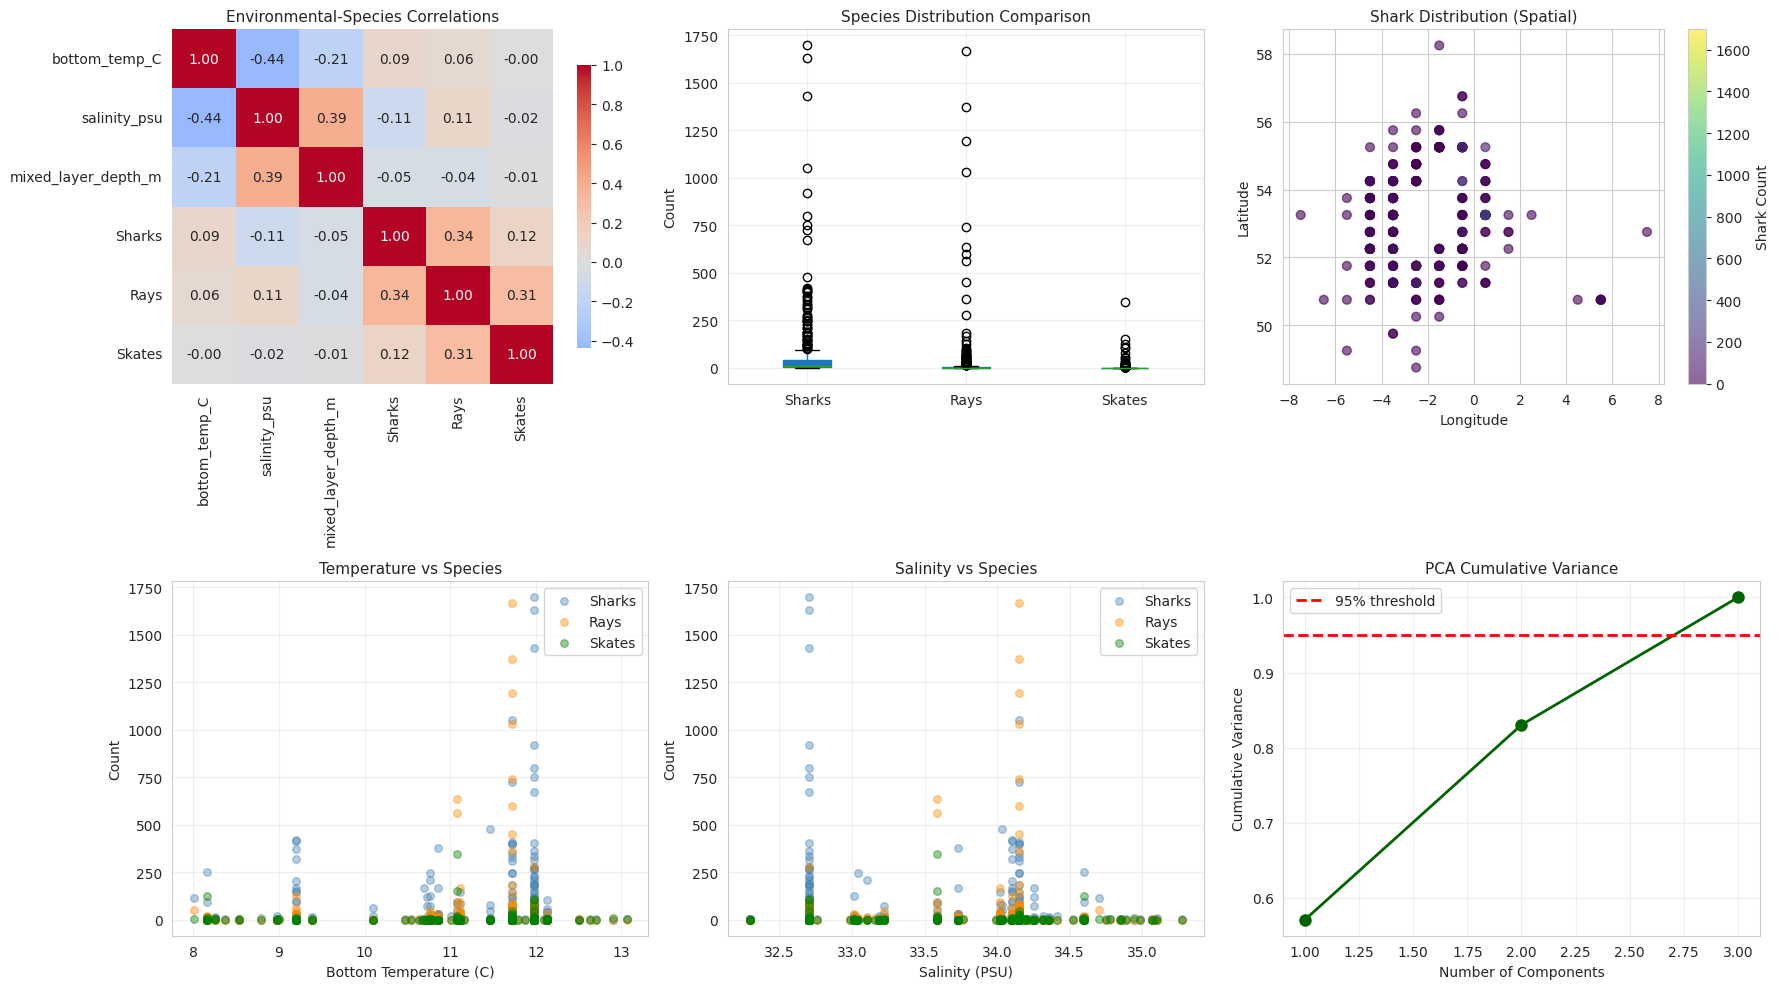

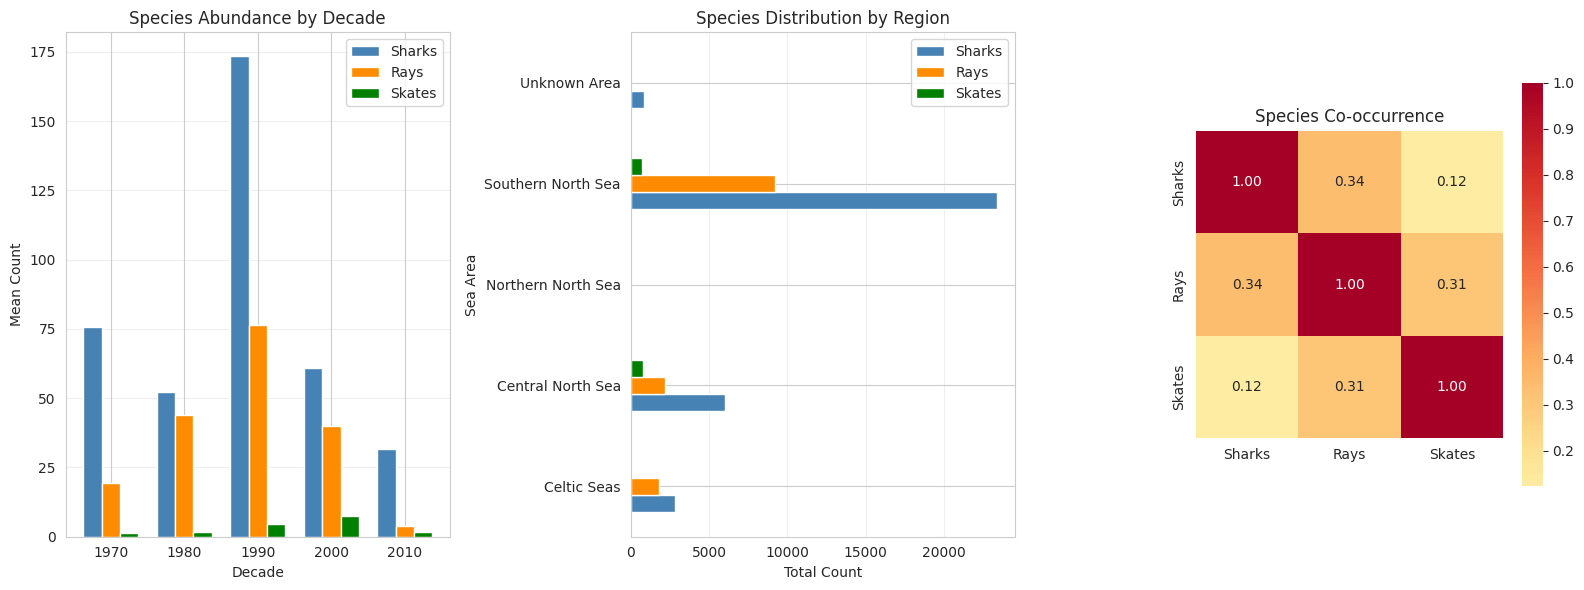

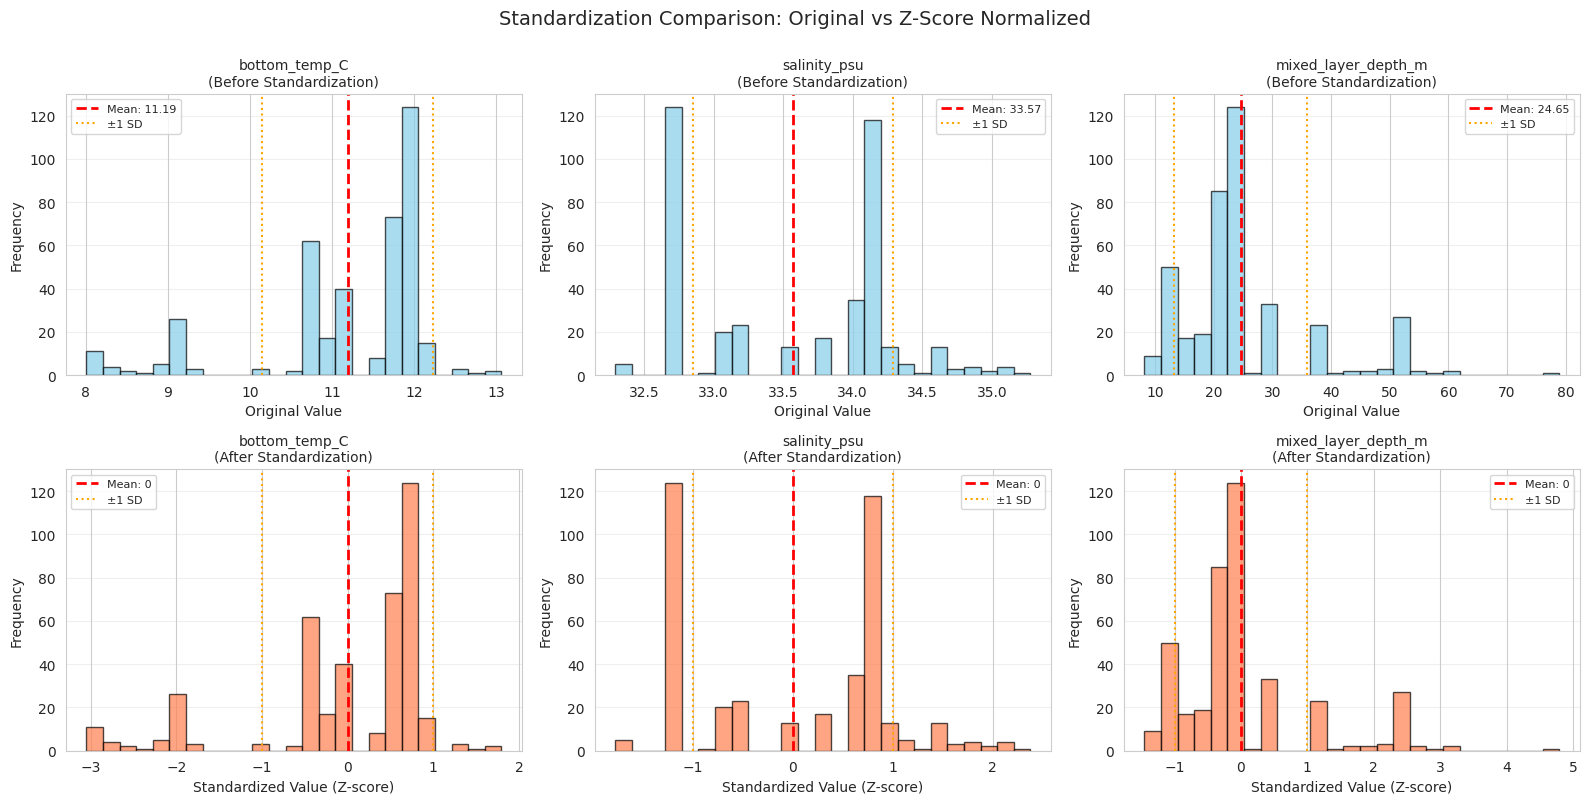

In [17]:
#Diagrams

sns.set_style("whitegrid")

fig1 = plt.figure(figsize=(18, 10))

ax = plt.subplot(2, 3, 1)
corr_data = pd.concat([X_train[env_cols], y_train_sharks, y_train_rays, y_train_skates], axis=1)
corr_data.columns = list(env_cols) + ['Sharks', 'Rays', 'Skates']
sns.heatmap(corr_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Environmental-Species Correlations', fontsize=11)

ax = plt.subplot(2, 3, 2)
species_data = pd.DataFrame({
    'Sharks': y_train_sharks.values,
    'Rays': y_train_rays.values,
    'Skates': y_train_skates.values
})
species_data. boxplot(ax=ax, patch_artist=True)
ax. set_ylabel('Count')
ax.set_title('Species Distribution Comparison', fontsize=11)
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 3)
ax.scatter(X_train['centroid_lon'], X_train['centroid_lat'],
           c=y_train_sharks, cmap='viridis', s=40, alpha=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Shark Distribution (Spatial)', fontsize=11)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Shark Count')

ax = plt.subplot(2, 3, 4)
ax.scatter(X_train['bottom_temp_C'], y_train_sharks, alpha=0.4, s=30, color='steelblue', label='Sharks')
ax. scatter(X_train['bottom_temp_C'], y_train_rays, alpha=0.4, s=30, color='darkorange', label='Rays')
ax.scatter(X_train['bottom_temp_C'], y_train_skates, alpha=0.4, s=30, color='green', label='Skates')
ax.set_xlabel('Bottom Temperature (C)')
ax.set_ylabel('Count')
ax.set_title('Temperature vs Species', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 5)
ax. scatter(X_train['salinity_psu'], y_train_sharks, alpha=0.4, s=30, color='steelblue', label='Sharks')
ax.scatter(X_train['salinity_psu'], y_train_rays, alpha=0.4, s=30, color='darkorange', label='Rays')
ax.scatter(X_train['salinity_psu'], y_train_skates, alpha=0.4, s=30, color='green', label='Skates')
ax.set_xlabel('Salinity (PSU)')
ax.set_ylabel('Count')
ax. set_title('Salinity vs Species', fontsize=11)
ax. legend()
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 6)
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
        marker='o', color='darkgreen', linewidth=2, markersize=8)
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance')
ax.set_title('PCA Cumulative Variance', fontsize=11)
ax. legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(16, 6))

ax = plt.subplot(1, 3, 1)
decade_sharks = X_train. groupby('Decade'). apply(lambda x: y_train_sharks.loc[x.index]. mean())
decade_rays = X_train.groupby('Decade'). apply(lambda x: y_train_rays.loc[x.index].mean())
decade_skates = X_train. groupby('Decade').apply(lambda x: y_train_skates.loc[x.index]. mean())
x_pos = np.arange(len(decade_sharks))
width = 0.25
ax.bar(x_pos - width, decade_sharks.values, width, label='Sharks', color='steelblue')
ax.bar(x_pos, decade_rays.values, width, label='Rays', color='darkorange')
ax.bar(x_pos + width, decade_skates. values, width, label='Skates', color='green')
ax.set_xlabel('Decade')
ax.set_ylabel('Mean Count')
ax.set_title('Species Abundance by Decade', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(decade_sharks. index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

ax = plt.subplot(1, 3, 2)
sea_area_data = df_clean. groupby('sea_area'). agg({
    'Total_Sharks': 'sum',
    'Total_Rays': 'sum',
    'Total_Skates': 'sum'
})
sea_area_data. plot(kind='barh', ax=ax, color=['steelblue', 'darkorange', 'green'])
ax.set_xlabel('Total Count')
ax.set_ylabel('Sea Area')
ax.set_title('Species Distribution by Region', fontsize=12)
ax.legend(['Sharks', 'Rays', 'Skates'])
ax.grid(True, alpha=0.3, axis='x')

ax = plt.subplot(1, 3, 3)
species_corr = pd.DataFrame({
    'Sharks': y_train_sharks.values,
    'Rays': y_train_rays.values,
    'Skates': y_train_skates.values
})
species_corr_matrix = species_corr.corr()
sns.heatmap(species_corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, ax=ax, square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Species Co-occurrence', fontsize=12)

plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(16, 8))

for i, col in enumerate(env_cols):
    ax = plt. subplot(2, 3, i + 1)
    X_train[col].hist(bins=25, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Original Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col}\n(Before Standardization)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    mean_val = X_train[col].mean()
    std_val = X_train[col].std()
    ax. axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1.5, label=f'±1 SD')
    ax.axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1.5)
    ax.legend(fontsize=8)

for i, col in enumerate(env_cols):
    ax = plt. subplot(2, 3, i + 4)
    X_train_scaled[col].hist(bins=25, ax=ax, color='coral', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Standardized Value (Z-score)')
    ax.set_ylabel('Frequency')
    ax. set_title(f'{col}\n(After Standardization)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean: 0')
    ax.axvline(-1, color='orange', linestyle=':', linewidth=1.5, label='±1 SD')
    ax.axvline(1, color='orange', linestyle=':', linewidth=1.5)
    ax.legend(fontsize=8)

plt.suptitle('Standardization Comparison: Original vs Z-Score Normalized', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


In [18]:
#Updating ds
df_clean.to_csv('species_distribution_clean.csv', index=False)
df = pd.read_csv('species_distribution_clean.csv')


In [19]:
#Model selection

print("\nModel to be Used:")
models_to_test = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

for model_name, model in models_to_test.items():
    print(f"  - {model_name}")

print("\nTargets:")
species_list = {
    'Sharks': (y_train_sharks, y_test_sharks),
    'Rays': (y_train_rays, y_test_rays),
    'Skates': (y_train_skates, y_test_skates)
}

for species in species_list.keys():
    print(f"  - {species}")

print(f"\nTotal models to train: {len(models_to_test)} × {len(species_list)} = {len(models_to_test) * len(species_list)}")

all_results = {}
trained_models = {}


Model to be Used:
  - Linear Regression
  - Ridge Regression
  - Random Forest
  - Gradient Boosting

Targets:
  - Sharks
  - Rays
  - Skates

Total models to train: 4 × 3 = 12


In [20]:
#Model training
for species_name, (y_train, y_test) in species_list.items():
    print(f"Currently Training: {species_name}")
    print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")

    all_results[species_name] = {}
    trained_models[species_name] = {}

    for model_name, model in models_to_test.items():
        print(f"\n{model_name}:\n")


        model.fit(X_train_scaled, y_train)
        trained_models[species_name][model_name] = model

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        y_train_pred = np.maximum(y_train_pred, 0)
        y_test_pred = np.maximum(y_test_pred, 0)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

        all_results[species_name][model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

        print(f"  Training R^2:    {train_r2:.3f}")
        print(f"  Test R^2:        {test_r2:.3f}")
        print(f"  CV R^2: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"  Training RMSE:  {train_rmse:.2f}")
        print(f"  Test RMSE:      {test_rmse:.2f}")
        print(f"  Training MAE:   {train_mae:.2f}")
        print(f"  Test MAE:       {test_mae:.2f}")

        overfit_gap = train_r2 - test_r2
        if overfit_gap > 0.2:
            print(f"  WARNING: Overfitting detected (gap: {overfit_gap:.3f})")
        elif test_r2 < 0:
            print(f"  WARNING: Model performs worse than baseline")

        if model_name == 'Linear Regression' and hasattr(model, 'coef_'):
            print(f"\n Environmental Factor Coeff:")
            for feature, coef in zip(selected_features, model.coef_):
                if feature in env_cols:
                    print(f"    {feature}: {coef:.4f}")



Currently Training: Sharks
Training samples: 402, Test samples: 101

Linear Regression:

  Training R^2:    0.043
  Test R^2:        0.116
  CV R^2: -0.095 ± 0.249
  Training RMSE:  180.48
  Test RMSE:      168.67
  Training MAE:   91.72
  Test MAE:       85.26

 Environmental Factor Coeff:
    bottom_temp_C: -30.3368
    salinity_psu: -27.6588
    mixed_layer_depth_m: -3.1758

Ridge Regression:

  Training R^2:    0.043
  Test R^2:        0.115
  CV R^2: -0.094 ± 0.247
  Training RMSE:  180.48
  Test RMSE:      168.73
  Training MAE:   91.69
  Test MAE:       85.31

Random Forest:

  Training R^2:    0.522
  Test R^2:        -0.055
  CV R^2: -0.620 ± 1.359
  Training RMSE:  127.51
  Test RMSE:      184.25
  Training MAE:   58.51
  Test MAE:       82.37

Gradient Boosting:

  Training R^2:    0.529
  Test R^2:        -0.034
  CV R^2: -0.975 ± 1.825
  Training RMSE:  126.57
  Test RMSE:      182.40
  Training MAE:   55.74
  Test MAE:       83.64
Currently Training: Rays
Training samples

In [21]:
#Model comparison

comparison_data = []
for species in species_list.keys():
    for model_name, metrics in all_results[species].items():
        comparison_data.append({
            'Species': species,
            'Model': model_name,
            'Train_R2': metrics['train_r2'],
            'Test_R2': metrics['test_r2'],
            'CV_R2': metrics['cv_mean'],
            'CV_Std': metrics['cv_std'],
            'Test_RMSE': metrics['test_rmse'],
            'Test_MAE': metrics['test_mae'],
            'Overfit_Gap': metrics['train_r2'] - metrics['test_r2']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Table:")
print(comparison_df. to_string(index=False))



best_models = {}
for species in species_list.keys():
    species_results = comparison_df[comparison_df['Species'] == species]
    best_idx = species_results['Test_R2'].idxmax()
    best = species_results.loc[best_idx]
    best_models[species] = best['Model']

    print(f"\n{species}:")
    print(f"  Best Model: {best['Model']}")
    print(f"  Test R²: {best['Test_R2']:.3f}")
    print(f"  CV R²: {best['CV_R2']:.3f} ± {best['CV_Std']:.3f}")
    print(f"  Test RMSE: {best['Test_RMSE']:.2f}")
    print(f"  Test MAE: {best['Test_MAE']:.2f}")
    print(f"  Overfit Gap: {best['Overfit_Gap']:.3f}")

    if best['Test_R2'] > 0.5:
        interpretation = "Strong predictive power"
    elif best['Test_R2'] > 0.3:
        interpretation = "Moderate predictive power"
    elif best['Test_R2'] > 0.1:
        interpretation = "Weak predictive power"
    else:
        interpretation = "Very weak predictive power"
    print(f"  Interpretation: {interpretation}")

print("Model Selection Summary")

for species, model in best_models.items():
    r2 = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_R2'].values[0]
    print(f"  {species}: {model} (R²={r2:.3f})")


Performance Table:
Species             Model  Train_R2    Test_R2      CV_R2    CV_Std  Test_RMSE  Test_MAE  Overfit_Gap
 Sharks Linear Regression  0.042539   0.115729  -0.095247  0.248943 168.668817 85.257396    -0.073189
 Sharks  Ridge Regression  0.042503   0.115126  -0.094153  0.246598 168.726307 85.309698    -0.072623
 Sharks     Random Forest  0.522036  -0.055147  -0.620221  1.359000 184.246250 82.367903     0.577184
 Sharks Gradient Boosting  0.529124  -0.034098  -0.974957  1.825345 182.399192 83.638652     0.563222
   Rays Linear Regression  0.042510  -0.387126  -0.796407  1.668953  63.732026 37.280084     0.429636
   Rays  Ridge Regression  0.042496  -0.386283  -0.789619  1.655259  63.712656 37.259747     0.428778
   Rays     Random Forest  0.449992  -6.068971  -7.487355 15.122741 143.872533 41.438341     6.518963
   Rays Gradient Boosting  0.456683  -5.859523 -11.871654 23.824927 141.725098 39.982258     6.316206
 Skates Linear Regression  0.016627  -0.994497  -0.260115  0.4

In [23]:
#feature importance

feature_importance_results = {}

for species in species_list.keys():
    print(f"{species. upper()} - Random Forest")

    rf_model = trained_models[species]['Random Forest']
    importances = rf_model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    feature_importance_results[species] = importance_df

    print("\nAll Features:")
    print(importance_df.to_string(index=False))

    env_only = importance_df[importance_df['Feature'].isin(env_cols)]
    print(f"\nEnvironmental Factors:")
    print(env_only.to_string(index=False))

    print(f"\nTop Environmental Factor: {env_only.iloc[0]['Feature']}")
    print(f"Importance Score: {env_only.iloc[0]['Importance']:.3f}")

    total_env_importance = env_only['Importance'].sum()
    print(f"Total Environmental Importance: {total_env_importance:.3f}")
    print(f"Spatial/Temporal Importance: {1 - total_env_importance:.3f}")


for factor in env_cols:
    print(f"\n{factor}:")
    for species in species_list.keys():
        imp_df = feature_importance_results[species]
        importance = imp_df[imp_df['Feature'] == factor]['Importance'].values[0]
        print(f"  {species}: {importance:.3f}")


SHARKS - Random Forest

All Features:
            Feature  Importance
             Decade    0.507523
       salinity_psu    0.198128
       centroid_lat    0.091555
       centroid_lon    0.089526
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Environmental Factors:
            Feature  Importance
       salinity_psu    0.198128
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Top Environmental Factor: salinity_psu
Importance Score: 0.198
Total Environmental Importance: 0.311
Spatial/Temporal Importance: 0.689

RAYS - Random Forest

All Features:
            Feature  Importance
             Decade    0.507523
       salinity_psu    0.198128
       centroid_lat    0.091555
       centroid_lon    0.089526
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Environmental Factors:
            Feature  Importance
       salinity_psu    0.198128
      bottom_temp_C    0.065899
mixed_layer_depth_m    0.047369

Top Environmental Factor: salinity

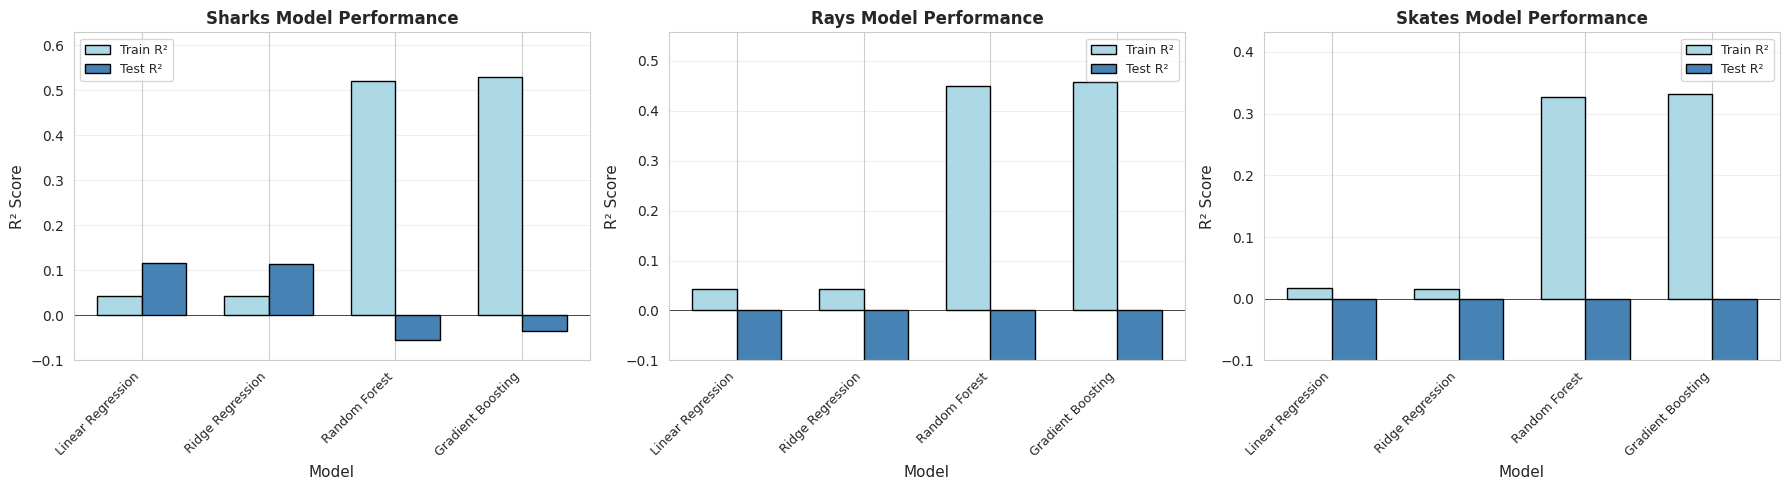

In [24]:
#Preformance Diagrams

fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, species in enumerate(species_list.keys()):
    ax = axes[idx]
    species_data = comparison_df[comparison_df['Species'] == species]

    x = np.arange(len(species_data))
    width = 0.35

    bars1 = ax.bar(x - width/2, species_data['Train_R2'], width, label='Train R²', color='lightblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, species_data['Test_R2'], width, label='Test R²', color='steelblue', edgecolor='black')

    ax. set_xlabel('Model', fontsize=11)
    ax.set_ylabel('R² Score', fontsize=11)
    ax.set_title(f'{species} Model Performance', fontsize=12, fontweight='bold')
    ax. set_xticks(x)
    ax.set_xticklabels(species_data['Model'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_ylim([-0.1, max(species_data['Train_R2']. max(), species_data['Test_R2'].max()) + 0.1])

plt.tight_layout()

plt.show()

Saved: feature_importance_all_species.png


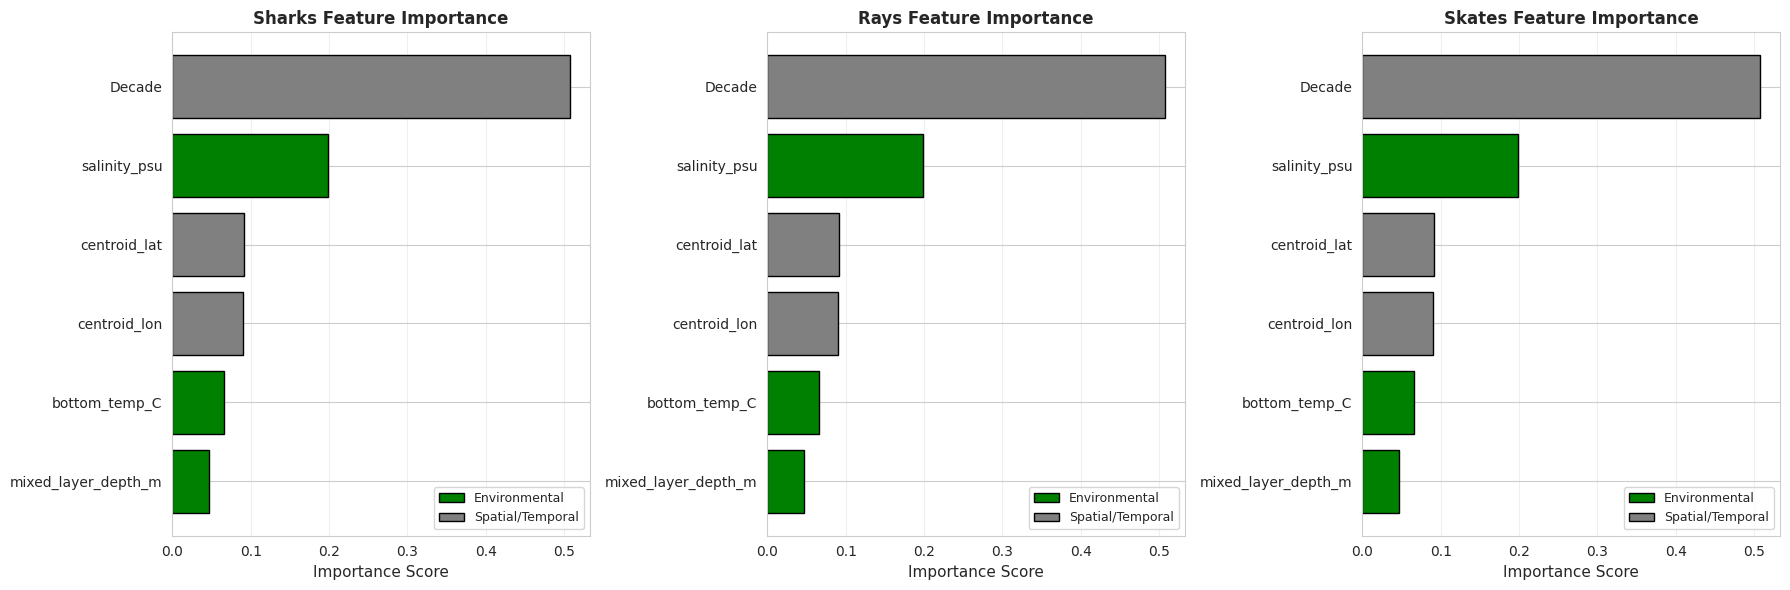

In [25]:
#Feature Importance Diagrams

fig2, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, species in enumerate(species_list.keys()):
    ax = axes[idx]
    importance_df = feature_importance_results[species]. sort_values('Importance', ascending=True)

    colors = ['green' if f in env_cols else 'gray' for f in importance_df['Feature']]

    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black')
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_title(f'{species} Feature Importance', fontsize=12, fontweight='bold')
    ax. grid(True, alpha=0.3, axis='x')

    legend_elements = [
        plt.Rectangle((0,0),1,1, fc='green', edgecolor='black', label='Environmental'),
        plt.Rectangle((0,0),1,1, fc='gray', edgecolor='black', label='Spatial/Temporal')
    ]
    ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

plt.tight_layout()

plt.show()

Saved: prediction_scatter_plots.png


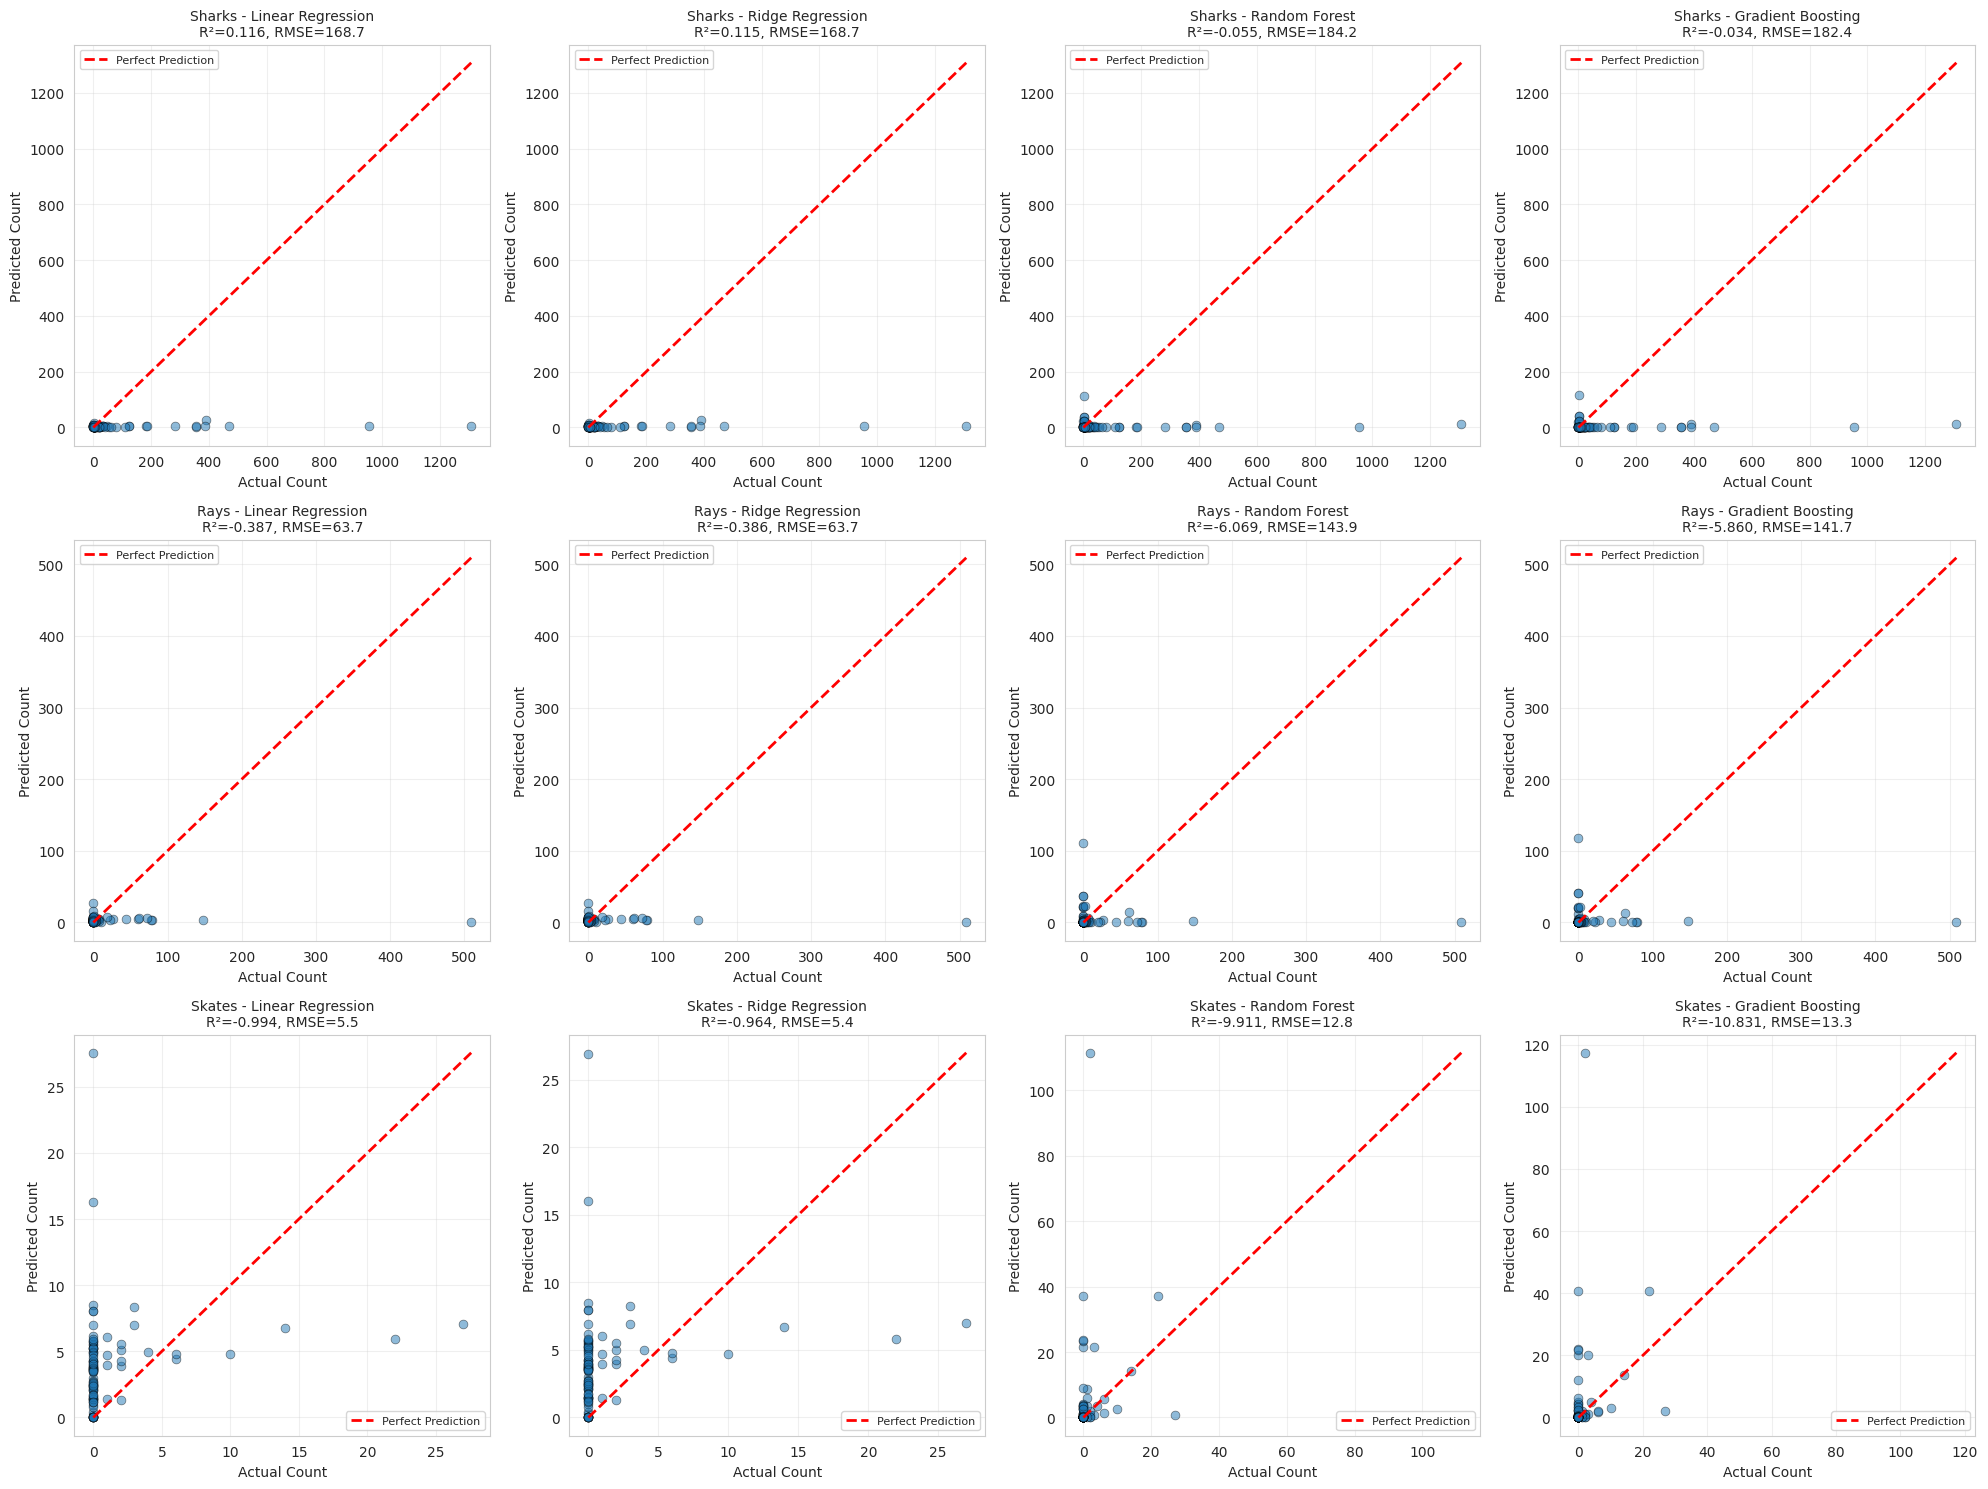

In [26]:
#Prediction Accuracy Diagrams

fig3, axes = plt.subplots(3, 4, figsize=(20, 15))

for species_idx, species in enumerate(species_list.keys()):
    y_train, y_test = species_list[species]

    for model_idx, model_name in enumerate(models_to_test.keys()):
        ax = axes[species_idx, model_idx]

        model = trained_models[species][model_name]
        y_pred = model.predict(X_test_scaled)
        y_pred = np.maximum(y_pred, 0)

        ax.scatter(y_test, y_pred, alpha=0.5, s=40, edgecolors='black', linewidth=0.5)

        max_val = max(y_test.max(), y_pred.max())
        ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

        r2 = all_results[species][model_name]['test_r2']
        rmse = all_results[species][model_name]['test_rmse']

        ax.set_xlabel('Actual Count', fontsize=10)
        ax.set_ylabel('Predicted Count', fontsize=10)
        ax.set_title(f'{species} - {model_name}\nR²={r2:.3f}, RMSE={rmse:.1f}', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()

plt.show()

In [28]:
#Summary

print("\nModeling Approach:")
print(f"  Models tested: {len(models_to_test)}")
print(f"  Species analyzed: {len(species_list)}")
print(f"  Total models trained: {len(models_to_test) * len(species_list)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features used: {len(selected_features)}")

print("\nBest Performing Models:")
for species, model in best_models.items():
    r2 = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_R2'].values[0]
    rmse = comparison_df[(comparison_df['Species']==species) & (comparison_df['Model']==model)]['Test_RMSE'].values[0]
    print(f"  {species}:")
    print(f"    Model: {model}")
    print(f"    Test R²: {r2:.3f}")
    print(f"    Test RMSE: {rmse:.2f}")

print("\nEnvironmental Factor Influence:")
for species in species_list.keys():
    env_importance = feature_importance_results[species][feature_importance_results[species]['Feature']. isin(env_cols)]
    top_factor = env_importance.iloc[0]['Feature']
    top_score = env_importance.iloc[0]['Importance']
    print(f"  {species}: {top_factor} (importance: {top_score:.3f})")

print("\nKey Findings:")
avg_r2 = comparison_df. groupby('Model')['Test_R2'].mean()
best_overall = avg_r2.idxmax()
print(f"  1. Best overall model type: {best_overall} (avg R²: {avg_r2[best_overall]:.3f})")

all_env_importance = pd.concat([feature_importance_results[s][feature_importance_results[s]['Feature'].isin(env_cols)] for s in species_list.keys()])
most_important_overall = all_env_importance.groupby('Feature')['Importance']. mean().idxmax()
print(f"  2. Most influential environmental factor: {most_important_overall}")

linear_avg = comparison_df[comparison_df['Model']=='Linear Regression']['Test_R2'].mean()
rf_avg = comparison_df[comparison_df['Model']=='Random Forest']['Test_R2'].mean()
if rf_avg > linear_avg + 0.1:
    print(f"  3. Non-linear relationships detected (RF R²={rf_avg:.3f} vs Linear R²={linear_avg:. 3f})")
else:
    print(f"  3.  Relationships are approximately linear")





Modeling Approach:
  Models tested: 4
  Species analyzed: 3
  Total models trained: 12
  Training samples: 402
  Test samples: 101
  Features used: 6

Best Performing Models:
  Sharks:
    Model: Linear Regression
    Test R²: 0.116
    Test RMSE: 168.67
  Rays:
    Model: Ridge Regression
    Test R²: -0.386
    Test RMSE: 63.71
  Skates:
    Model: Ridge Regression
    Test R²: -0.964
    Test RMSE: 5.44

Environmental Factor Influence:
  Sharks: salinity_psu (importance: 0.198)
  Rays: salinity_psu (importance: 0.198)
  Skates: salinity_psu (importance: 0.198)

Key Findings:
  1. Best overall model type: Ridge Regression (avg R²: -0.412)
  2. Most influential environmental factor: salinity_psu
  3.  Relationships are approximately linear

Files Generated:
  - model_performance_comparison.png
  - feature_importance_all_species.png
  - prediction_scatter_plots. png

Variables Available:
  - trained_models: Dictionary of all trained models
  - all_results: Dictionary of all performanc